In [1]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import fast_dsift, double_igo, no_op

from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, plot_graph

from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    SSDForwardNewtonSimultaneous,
    SSDForwardNewtonAlternated,
    SSDInverseNewtonSimultaneous,
    SSDInverseNewtonAlternated,
    SSDAsymmetricNewtonSimultaneous,
    SSDAsymmetricNewtonAlternated,
    SSDBidirectionalNewtonSimultaneousCombined,
    SSDBidirectionalNewtonSimultaneous,
    SSDBidirectionalNewtonAlternated,
    SSDBidirectionalNewtonAlternatedCombined)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=None):
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - done.                           


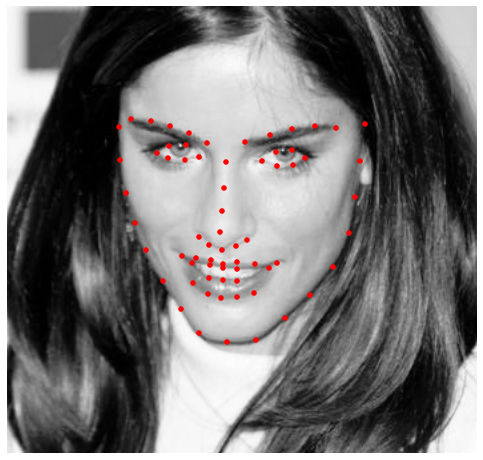

In [3]:
visualize_images(training_images)

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/testset/', 
                           verbose=True, max_images=10):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

Importing assets: [==========] 100% (10/10) - done.                             


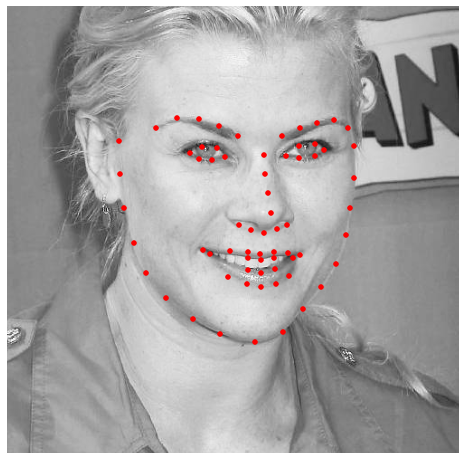

In [5]:
visualize_images(test_images)

## Build Active Appearance Models

In [40]:
features = no_op
diagonal = 200
scales = (0.5, 1)
max_shape_components= 25
max_appearance_components = 250

#### AAM

In [41]:
aam = HolisticAAM(
    training_images, 
    group='ibug_face_66', 
    verbose=True,
    features=features,
    diagonal=diagonal,
    scales=scales,
    max_shape_components=max_shape_components,
    max_appearance_components=max_appearance_components)

Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done


## Fit Active Appearance Models

In [42]:
sampling_step = [2, 2]
n_shape = [3, 12]
n_appearance = [50, 100]
l = 0.5

#### AAM Fitter

In [43]:
fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDForwardNewtonSimultaneous),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_2 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDForwardNewtonAlternated),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_3 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDInverseNewtonSimultaneous),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_4 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDInverseNewtonAlternated), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_5 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDAsymmetricNewtonSimultaneous), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_6 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDAsymmetricNewtonAlternated),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_7 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalNewtonSimultaneous), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_8 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalNewtonSimultaneousCombined), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_9 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalNewtonAlternated),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_10 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDBidirectionalNewtonAlternatedCombined),
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

#### Fitting loop

In [44]:
fitters = [fitter_1,
           fitter_2,
           fitter_3,
           fitter_4,
           fitter_5,
           fitter_6,
           fitter_7,
           fitter_8,
           fitter_9,
           fitter_10]

n_fitters = len(fitters)
legend_entries=['ini', 
                'f_s', 'f_a', 
                'i_s', 'i_a', 
                'a_s', 'a_a', 
                'b_s', 'b_s_c', 'b_a', 'b_a_c']

fitters_results = []

for j, i in enumerate(test_images[:10]):
    
    np.random.seed(j)
    
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitters[0].noisy_shape_from_shape(gt_s, noise_percentage=0.01)

    for fitter in fitters:
        
        fr = fitter.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Visualize Results

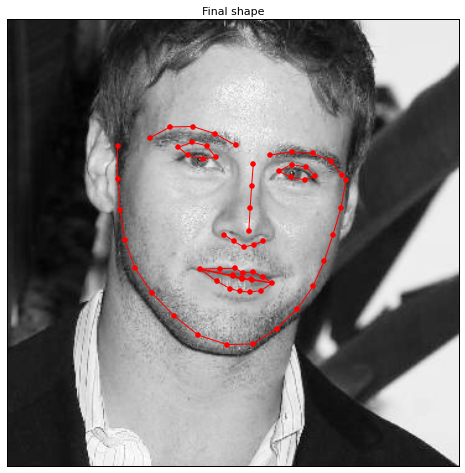

In [45]:
visualize_fitting_result(fitters_results)

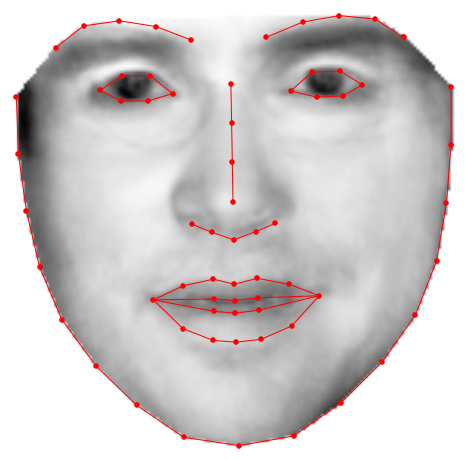

In [49]:
fr = fitters_results[17]

visualize_images(fr.appearance_reconstructions)

In [50]:
errors = [[fr.initial_error() for fr in fitters_results[::n_fitters]]]

for j in range(n_fitters):
    errors.append([fr.final_error() for fr in fitters_results[j::n_fitters]])

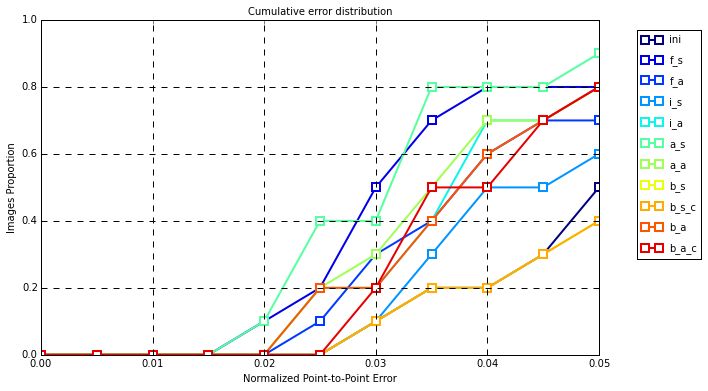

In [51]:
plot_ced(errors, legend_entries=legend_entries)

In [52]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:', np.mean(e), '\tstd:', np.std(e), '\tmedian:', np.median(e)

ini 	mean: 0.0519069983916 	std: 0.014780275445 	median: 0.0513341718621
f_s 	mean: 0.0334018940227 	std: 0.0115763601625 	median: 0.0299347898188
f_a 	mean: 0.0410985456065 	std: 0.0140815771636 	median: 0.0395586315618
i_s 	mean: 0.223070481331 	std: 0.419868977649 	median: 0.044775371065
i_a 	mean: 0.0376910407522 	std: 0.011899270215 	median: 0.0352982121457
a_s 	mean: 0.0316446922464 	std: 0.0104642921735 	median: 0.0329482137388
a_a 	mean: 0.0382943260955 	std: 0.0129417855359 	median: 0.0362555133443
b_s 	mean: 0.0910188489952 	std: 0.0939848435316 	median: 0.0577725014566
b_s_c 	mean: 0.0910188489969 	std: 0.0939848435307 	median: 0.0577725014448
b_a 	mean: 0.0386315899665 	std: 0.0126453346597 	median: 0.0358828237222
b_a_c 	mean: 0.0399287907297 	std: 0.0116221124692 	median: 0.0380376113785


In [28]:
mean_errors = []
median_errors = []
for j in range(n_fitters):
    errors = np.asarray([fr.errors() for fr in fitters_results[j::n_fitters]])
    mean_errors.append(np.mean(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

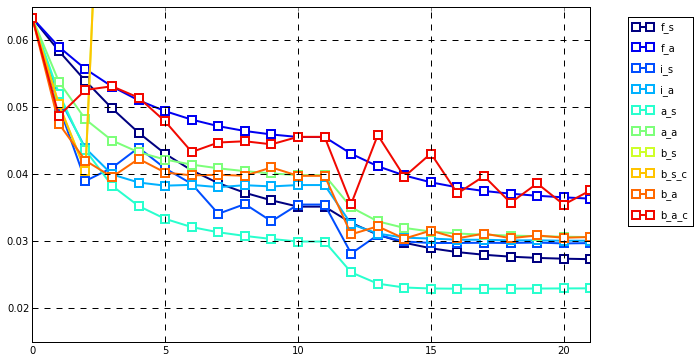

In [29]:
plot_graph(np.arange(0, 22), 
           mean_errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

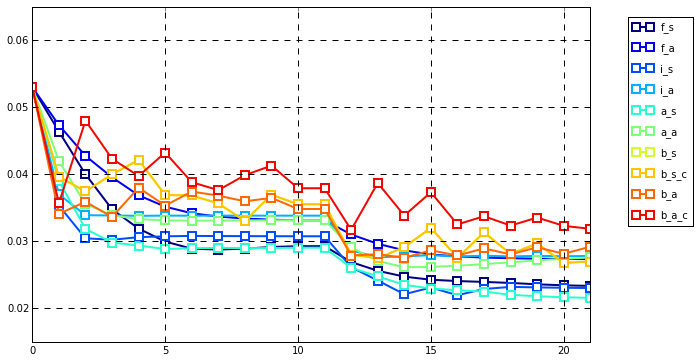

In [17]:
plot_graph(np.arange(0, 22), 
           median_errors, 
           y_axis_limits=(0.015, 0.065),
           legend_entries=legend_entries[1:])

In [18]:
%timeit fr = fitter_1.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_2.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_4.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_5.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = fitter_6.fit_from_shape(i, s, gt_shape=gt_s, max_iters=20) 

1 loops, best of 3: 381 ms per loop
1 loops, best of 3: 369 ms per loop
1 loops, best of 3: 386 ms per loop
1 loops, best of 3: 374 ms per loop
1 loops, best of 3: 435 ms per loop
1 loops, best of 3: 419 ms per loop


In [19]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [20]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 